In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import seaborn as sns
import time
import random

In [2]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import joblib

In [3]:
path = '../data/df_cleaned__by_artist.csv'
df = pd.read_csv(path)
df.head()
del df['Unnamed: 0']

# Data Cleaning

Features Selection
Looking closely at the features, there are some features to consider whether to include in the final model or not:

id: id is unique for each track, therfore cannot assist a model and will be dropped.

name: There are 132,940 unique values. In our opinion, this is a problematic categorical feature to insert in a model, and will be dropped.

artists: there are 33,375 unique features. Since we enticipate the artist will influence the popularity of the track, this feature will remain and be handled seperatley.

release_date: The 'year' feature is a derivative to the 'release_date' feature, therfore one of them should be excluded. Since the release date contains rows with full date and others with year only, the release_date will be dropped.

In [4]:
vc = df['artists'].value_counts()
vc_gt100 = vc[vc.values >= 100].index
df = df[df['artists'].isin(vc_gt100)]

In [5]:
# Cleaning duplicated data
print(df.duplicated().sum(),'duplicated data in the current data frame')
df = df[~df.duplicated()==1]
df.shape

1241 duplicated data in the current data frame


(59828, 15)

In [6]:
min(df['loudness'])

0.0

# Preprocessing

In [7]:
X = copy.deepcopy(df)
X.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,artists
1,0.997992,0.383603,0.051316,0.0135,0.0,0.901,0.727273,0.0763,0.494026,1.0,0.00,0.047678,0.344019,0.0767,Robert Schumann
2,0.997992,0.383603,0.051316,0.0135,0.0,0.901,0.727273,0.0763,0.494026,1.0,0.00,0.047678,0.344019,0.0767,Vladimir Horowitz
4,0.998996,0.790486,0.032538,0.1300,0.0,0.887,0.090909,0.1110,0.708887,0.0,0.00,0.095562,0.442470,0.7200,Francisco Canaro
5,0.993976,0.212551,0.126450,0.2040,0.0,0.908,1.000000,0.0980,0.676079,1.0,0.01,0.043756,0.254614,0.0693,Frédéric Chopin
6,0.993976,0.212551,0.126450,0.2040,0.0,0.908,1.000000,0.0980,0.676079,1.0,0.01,0.043756,0.254614,0.0693,Vladimir Horowitz


In [8]:
song_features = pd.DataFrame()
# normalizer instance
scaler = MinMaxScaler()
for col in X.columns:      # excluding year col i.e, of int64 type
    if col != 'artists' and col != 'predicted_genres':
        scaler.fit(X[[col]])
        song_features[col] = scaler.transform(X[col].values.reshape(-1,1)).ravel() 

In [9]:
song_features

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence
0,0.997992,0.390319,0.102673,0.0135,0.0,0.901902,0.727273,0.0763,0.521456,1.0,0.00,0.047678,0.351502,0.076777
1,0.997992,0.390319,0.102673,0.0135,0.0,0.901902,0.727273,0.0763,0.521456,1.0,0.00,0.047678,0.351502,0.076777
2,0.998996,0.804325,0.065102,0.1300,0.0,0.887888,0.090909,0.1110,0.748248,0.0,0.00,0.095562,0.452094,0.720721
3,0.993976,0.216272,0.253000,0.2040,0.0,0.908909,1.000000,0.0980,0.713617,1.0,0.01,0.043756,0.260152,0.069369
4,0.993976,0.216272,0.253000,0.2040,0.0,0.908909,1.000000,0.0980,0.713617,1.0,0.01,0.043756,0.260152,0.069369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59823,0.004819,0.778579,0.072584,0.7470,1.0,0.005365,0.818182,0.5880,0.902423,1.0,0.70,0.047472,0.564830,0.068769
59824,0.580321,0.516993,0.107818,0.4620,0.0,0.000000,1.000000,0.7210,0.867396,1.0,0.70,0.027348,0.406392,0.304304
59825,0.023695,0.798146,0.085066,0.7200,1.0,0.000000,1.000000,0.1140,0.903316,0.0,0.66,0.199174,0.649181,0.490490
59826,0.069679,0.903193,0.084854,0.5540,1.0,0.000000,0.090909,0.0521,0.894191,1.0,0.65,0.311662,0.527734,0.585586


In [10]:
# KMeans instance
km = KMeans()
k_rng = range(1,200)  # k value
sse = [] # sse value for each k
for i in k_rng:
    km = KMeans(n_clusters = i)
    km.fit(song_features.sample(1000))
    # calculating sse
    sse.append(km.inertia_) 

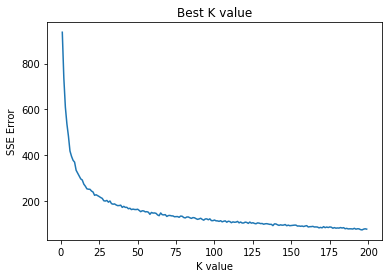

In [11]:
plt.plot(k_rng,sse)
plt.xlabel('K value')
plt.ylabel('SSE Error')
plt.title('Best K value')
# plt.ylim(0,400)
# plt.xlim(0,100)
plt.show()

In [12]:
def sumtopk(values, k):
    if k>len(values):
        k = len(values)
    values_c = np.partition(values, -1*k)
    output = sum(values_c[-k:])
    return output

In [13]:
song_features = pd.DataFrame()
# normalizer instance
scaler = MinMaxScaler()
for col in X.columns:      # excluding year col i.e, of int64 type
    if col not in ['artists','predicted_genres']:
        scaler.fit(X[[col]])
        song_features[col] = scaler.transform(X[col].values.reshape(-1,1)).ravel() 

np.random.seed(3)
k = 10
km = KMeans(n_clusters=k)
predicted_genres = km.fit_predict(song_features)

In [14]:
song_features['predicted_genres'] = predicted_genres
song_features['predicted_genres'] = song_features['predicted_genres'].apply(lambda x: 'Genre'+ str(x))

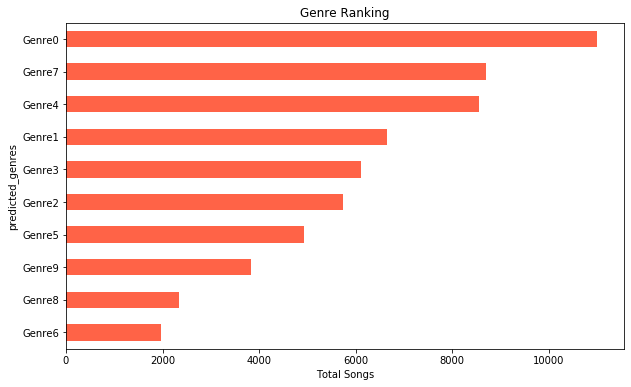

In [15]:
genres_grp = song_features.groupby(['predicted_genres']).size()
plt.figure(figsize=(10,6))
genres_grp.sort_values(ascending=True).plot.barh(color='tomato')
plt.xlabel('Total Songs')
plt.title('Genre Ranking')
plt.show()

In [16]:
joblib.dump(km , '../model/km_%d_freq_artists.pkl'%k)

['../model/km_10_freq_artists.pkl']

In [17]:
X.to_csv('../data/df_cleaned.csv')
song_features['predicted_genres'].to_csv('../data/df_cleaned_genre_%d.csv'%k)

In [18]:
X['predicted_genres'] = song_features['predicted_genres'].values
l = []
for artist in vc_gt100:
    a = X[X['artists'] == artist]
    l.append(a['predicted_genres'].value_counts())
for j in range(1,k//2):
    per = []
    for i in l:
        per.append(sumtopk(i.values,k//j)/sum(i.values))
    print('top %d in %d: %f'%(k//j, k, np.mean(per)))

top 10 in 10: 1.000000
top 5 in 10: 0.971079
top 3 in 10: 0.859732
top 2 in 10: 0.716734


In [19]:
#clf = joblib.load('../model//km_20.pkl')

In [20]:
#predicted_genres = clf.fit_predict(song_features)
#song_features['predicted_genres'] = predicted_genres
#song_features['predicted_genres'] = song_features['predicted_genres'].apply(lambda x: 'Genre'+ str(x))

In [21]:
rndperm = np.random.permutation(df.shape[0])

In [22]:
N = 10000
df_subset = song_features.loc[rndperm[:N],:].copy()

In [23]:
data_subset = df_subset.drop(labels='predicted_genres',axis=1).values

In [24]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=10, perplexity=100, n_iter=600)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.087s...
[t-SNE] Computed neighbors for 10000 samples in 1.914s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.211637
[t-SNE] Computed conditional probabilities in 1.257s
[t-SNE] Iteration 50: error = 82.7564468, gradient norm = 0.0110372 (50 iterations in 1.575s)
[t-SNE] I

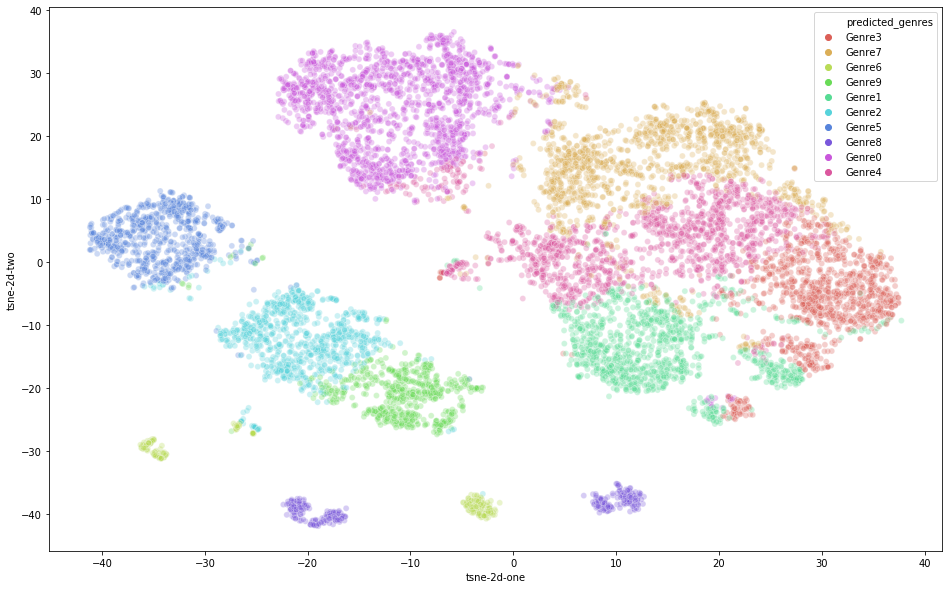

In [25]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="predicted_genres",
    palette=sns.color_palette("hls", k),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [26]:
pca_11 = PCA(n_components=11)
pca_result_11 = pca_11.fit_transform(data_subset)

In [27]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=10, perplexity=100, n_iter=600)
tsne_pca_results = tsne.fit_transform(pca_result_11)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.012s...
[t-SNE] Computed neighbors for 10000 samples in 1.314s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.201257
[t-SNE] Computed conditional probabilities in 1.269s
[t-SNE] Iteration 50: error = 82.2056274, gradient norm = 0.0176412 (50 iterations in 1.539s)
[t-SNE] I

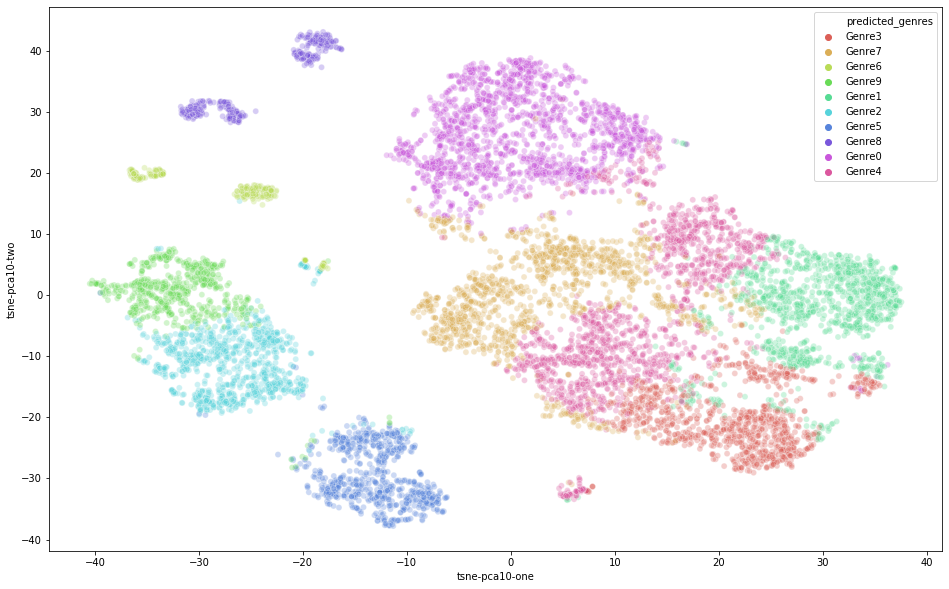

In [28]:
df_subset['tsne-pca10-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca10-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-pca10-one", y="tsne-pca10-two",
    hue="predicted_genres",
    palette=sns.color_palette("hls", k),
    data=df_subset,
    legend="full",
    alpha=0.3,
)